# Capstone 2 Project - News Headline Impact to Stock Market

## Problem Statement
Can news headlines be used to predict stock market movements for more than 60% of the time?

### Section 1. Data Wrangling

#### 1.1 Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk import stem
from nltk.tokenize import sent_tokenize, word_tokenize

#### 1.2 Import Data and Initial Data Check

In [2]:
path = os.getcwd()
print(path)

C:\Users\j9903\Desktop\SpringBoard\Assignments\Capstone Project 2


In [3]:
df = pd.read_csv(path + '\\Data\\Raw\\reuters_headlines.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


In [4]:
df.head(10)

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...
5,Wall Street Week Ahead: Fund managers navigate...,Jul 17 2020,Investors are searching for bargains in the wo...
6,Take Five: Hoping for that V-shape in earnings,Jul 17 2020,We knew Q2 earnings would be dire but the hope...
7,Evictions nearly back to pre-pandemic levels i...,Jul 17 2020,Landlords in some areas of the United States a...
8,Google bans ads on coronavirus conspiracy theo...,Jul 17 2020,Alphabet Inc's Google said on Friday it would ...
9,"Flight to suburbs boosts U.S. homebuilding, bu...",Jul 17 2020,U.S. homebuilding increased in June by the mos...


In [5]:
# Convert string to datetime 
df['DateTime']= pd.to_datetime(df['Time'],format='%b %d %Y')
df.drop('Time', axis=1, inplace=True)
#Reorder columns and sort by datetime
df = df[['DateTime', 'Headlines','Description']]
df.sort_values(by='DateTime')
df.head(10)

,DateTime,Headlines,Description
0,2020-07-18,TikTok considers London and other locations fo...,TikTok has been in discussions with the UK gov...
1,2020-07-18,Disney cuts ad spending on Facebook amid growi...,Walt Disney has become the latest company to ...
2,2020-07-18,Trail of missing Wirecard executive leads to B...,Former Wirecard chief operating officer Jan M...
3,2020-07-18,Twitter says attackers downloaded data from up...,Twitter Inc said on Saturday that hackers were...
4,2020-07-17,U.S. Republicans seek liability protections as...,A battle in the U.S. Congress over a new coron...
5,2020-07-17,Wall Street Week Ahead: Fund managers navigate...,Investors are searching for bargains in the wo...
6,2020-07-17,Take Five: Hoping for that V-shape in earnings,We knew Q2 earnings would be dire but the hope...
7,2020-07-17,Evictions nearly back to pre-pandemic levels i...,Landlords in some areas of the United States a...
8,2020-07-17,Google bans ads on coronavirus conspiracy theo...,Alphabet Inc's Google said on Friday it would ...
9,2020-07-17,"Flight to suburbs boosts U.S. homebuilding, bu...",U.S. homebuilding increased in June by the mos...


In [6]:
df.shape

(32770, 3)

#### 1.3 Data Cleaning

In [7]:
#Check missing data
print(df.isnull().values.any())
print(df.isnull().sum().sum())

False
0


In [8]:
#Check duplicate data
df[df.duplicated(['Headlines'])]

,DateTime,Headlines,Description
606,2020-07-07,U.S. hiring vaults to record high in May; new ...,U.S. hiring surged to a record high in May and...
613,2020-07-07,Wirecard administrator sees strong interest fr...,The administrator of collapsed German payments...
824,2020-07-01,Factbox: More companies join Facebook ad boyco...,A long list of companies have pulled advertisi...
998,2020-06-29,Factbox: More companies join Facebook ad boyco...,A long list of companies have pulled advertisi...
1232,2020-06-24,Factbox: More U.S. companies join Facebook ad ...,A handful of U.S. companies have pulled advert...
...,...,...,...
32375,2018-03-28,"SoftBank Vision Fund, Saudi Arabia to create w...",SoftBank Group Corp's Vision Fund will invest...
32406,2018-03-27,Companies clamp down on crypto ads as regulato...,A growing number of internet companies are ban...
32503,2018-03-25,Take Five: World markets themes for the week a...,Following are five big themes likely to domina...
32578,2018-03-23,Tencent loses $24 billion in market cap after ...,China's Tencent Holdings Ltd saw its shares d...


In [9]:
df.drop_duplicates(subset=['Headlines'], keep="first", inplace=True)
df.shape

(32575, 3)

In [10]:
df[df.duplicated(['Headlines'])]

,DateTime,Headlines,Description


***Outlier Detection*** Outliers detection below is based on the length of the headlines. At this stage, it is not clear how the length of the headlines is relevant to the sentiment of the headline so the analysis will be performed but those "outliers" will not be removed just yet.

In [11]:
#Check headline length
df['Length']= df.Headlines.str.len()

Text(0.5, 1.0, 'Number of Headline Characters')

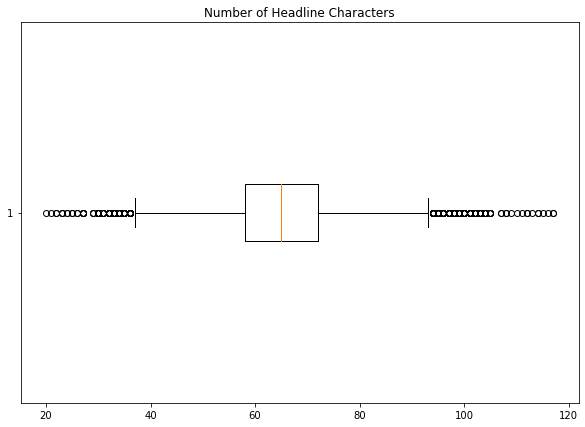

In [12]:
fig = plt.figure(1, figsize=(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(df['Length'], vert=False)
ax.set_title('Number of Headline Characters')

#### 1.4 Text Preprocessing

In [13]:
#Remove punctuation
#Sample Input:Take Five: Hoping for that V-shape in earnings
#Sample Output: Take Five Hoping for that Vshape in earnings
def removePunc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

In [14]:
#Make all characters lower cases
#Sample input: Take Five: Hoping for that V-shape in earnings
#Sample Ooutput: take five: hoping for that v-shape in earnings
def toLower(s):
    return s.lower()

In [15]:
#Remove digits
#Sample Input: S&P 500 ends higher as traders weigh stimulus and virus worries
#Sample Output: S&P  ends higher as traders weigh stimulus and virus worries
def removeDigit(s):
    return str("".join(filter(lambda x: not x.isdigit(), s)))

In [16]:
#Remove stop words
#Sample Input: Take Five: Hoping for that V-shape in earnings
#Sample Output: Take Five: Hoping V-shape earnings
def removeStopWords(s):
    return gensim.parsing.preprocessing.remove_stopwords(s)

***Stemming***
There are two techniques available for text normalization in NLP: stemming and lemmatization. In this project, the Python nltk (Natural Language Tool Kit) package provided by Python will be used for stemming tasks. There are several algorithms available for stemming in nltk package and for simplicity and efficiency, PorterStemmer, using siffix stripping to produce stems, will be used here. Because PorterStemmer does not keep a lookup table for actual stems of the word so it often generat stems that are not actual English words.

In [17]:
#Stemming
#Sample Input: Take Five: Hoping for that V-shape in earnings
#Sample Output: take five : hope for that v-shape in earn 
stemmer = stem.PorterStemmer()
def stemming(s):
    tokenwords = word_tokenize(s)
    line = []
    for word in tokenwords:
        line.append(stemmer.stem(word))
        line.append(' ')
    return "".join(line)

In [18]:
#Add a new column to apply text preprocessing functions to the Headline column
df['Cleaned Headlines'] = df['Headlines'].map(removePunc).map(toLower).map(removeDigit).map(removeStopWords).map(stemming)
df[['Headlines', 'Cleaned Headlines']].head(10)

,Headlines,Cleaned Headlines
0,TikTok considers London and other locations fo...,tiktok consid london locat headquart
1,Disney cuts ad spending on Facebook amid growi...,disney cut ad spend facebook amid grow boycott...
2,Trail of missing Wirecard executive leads to B...,trail miss wirecard execut lead belaru der spi...
3,Twitter says attackers downloaded data from up...,twitter say attack download data nonverifi acc...
4,U.S. Republicans seek liability protections as...,republican seek liabil protect coronaviru aid ...
5,Wall Street Week Ahead: Fund managers navigate...,wall street week ahead fund manag navig night ...
6,Take Five: Hoping for that V-shape in earnings,hope vshape earn
7,Evictions nearly back to pre-pandemic levels i...,evict nearli prepandem level area cleveland fe...
8,Google bans ads on coronavirus conspiracy theo...,googl ban ad coronaviru conspiraci theori cont...
9,"Flight to suburbs boosts U.S. homebuilding, bu...",flight suburb boost homebuild covid surg erod ...


In [19]:
#Review the length of the headlines
df['Length']= df['Cleaned Headlines'].str.len()
#print(df[df['Length']==df['Length'].max()])
df['Length'].max()

90

Text(0.5, 1.0, 'Number of Cleaned Headline Characters')

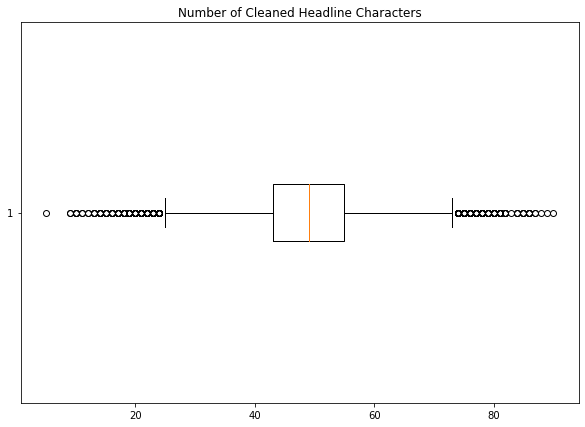

In [20]:
fig1 = plt.figure(1, figsize=(10, 7))
ax1 = fig1.add_subplot(111)
bp1 = ax1.boxplot(df['Length'], vert=False)
ax1.set_title('Number of Cleaned Headline Characters')

In [21]:
#Reorder columns
df = df[['DateTime', 'Cleaned Headlines','Headlines','Description','Length']]
#Save the cleanned data to a csv file
df.to_csv(path + '\\Data\\Cleaned\\cleaned_data.csv',index=False)

### Section 2. Exploratory Data Analysis

### Section 3. Modeling and Analysis

### Section 4. Conclusion